# Analysis of $D^{*+}\rightarrow D^{0}\pi^+, D^0\rightarrow K^{0}_s \pi^+\pi^{-}\pi^0$ 

## 1. Getting ready

Start by creating a path and reading in an mDST file from the MC12 "mixed" sample. The samples downloaded to KEKCC are noted in https://agira.desy.de/browse/BIIDP-1226.

In [1]:
# I'll help you out with the first few lines. We need to import the helper functions we want to use.
import basf2 as b2
import modularAnalysis as ma

# Define the path
path = b2.create_path()

mixed = False
# Define input file(s)
if mixed:
    #fns = '/ghi/fs01/belle/MC/release-03-01-00/DB00000547/MC12b/prod00007797/s00/e1003/4S/r00000/mixed/mdst/sub00'
    fns = '/ghi/fs01/belle2/bdata/MC/release-03-01-00/DB00000547/MC12b/prod00007392/s00/e1003/4S/r00000/mixed/mdst/sub00/'
    import glob
    inputfn = glob.glob(fns+'/*0183.*')
    print('Use input mixed files ',*inputfn)
else:
    inputfn = ['DstartoD0pi_D0toKspipipi0.mdst.root','DstartoD0pi_D0toKspipipi0_1000.mdst.root']
    
    print('Use input signal file ',*inputfn)

generatorOnly = False
if generatorOnly:
    ma.inputMdstList('default',inputfn,path=path)
else:
    ma.inputMdstList('default',inputfn,path=path)

# try to get MC truth info    
#Dstmesons = ('D*+:gen','')
#ma.fillParticleListFromMC(Dstmesons, True)
#ma.matchMCTruth('D*+:gen')

    

Welcome to JupyROOT 6.14/06
Use input signal file  DstartoD0pi_D0toKspipipi0.mdst.root DstartoD0pi_D0toKspipipi0_1000.mdst.root


## 2. Reconstruct final state particles

Now we can start by creating ParticleLists for the final state particles (FSP). In this case we only need kaon and pion lists. We can either use the standard ParticleLists (see https://software.belle2.org/sphinx/release-03-01-04/analysis/doc/StandardParticles.html?highlight=stdcharged) or define our own criteria.

In [2]:
# Fill the kaon and pion particle lists
import stdCharged, stdV0s, stdPhotons, stdPi0s
stdCharged.stdPi("higheff",path=path)
#stdCharged.stdK("higheff",path=path)
stdCharged.stdPi("loose",path=path)
stdCharged.stdPi("all",path=path)
#stdCharged.stdK("loose",path=path)
stdV0s.stdKshorts(path=path)#makes ‘K_S0:all’
stdPi0s.stdPi0s("looseFit",path=path)
#stdPhotons.stdPhotons('pi0', path=path) # ‘gamma:pi0’ gamma list for pi0 list
# defining some track quality cuts

# Now fill the particle lists and apply the cut/requirement


## 3. Reconstruct the $\pi^0$, $K_S^0$, $D^0$, $D^{*}$

Now we can combine the Particles in our kaon and pion ParticleLists to build the composite ParticleList. We can immediatly impose some requirements on the $B^0$ or apply cuts later on.

In [3]:
#!b2help-particles D*+
#!b2help-particles D0

In [4]:
# Define decay string
#ma.reconstructDecay('pi0:gg -> gamma:pi0 gamma:pi0','0.13 < M < 0.16',path=path)
ma.reconstructDecay('D0:K2ppz -> K_S0:all pi+:loose pi-:loose pi0:looseFit','1.75 < M < 1.95',path=path)
ma.reconstructDecay('D*+:Dpi -> D0:K2ppz pi+:all','massDifference(0)<0.16',path=path)

ma.vertexTree('D*+:Dpi',-9999.,path=path)
ma.buildEventShape(path=path)
#from Analysis import ParticlePrinter

[INFO] Creating particle lists pi+:evtshape and gamma:evtshape to get the event shape variables.
[INFO] Using the default lists for the EventShape module.


In principle you could fill all kinds of particleLists like this (they could stay empty if no candidates match your requirements). The idea however is always to start from the FSPs and step by step reconstruct their mothers (e.g. a $D^0$ from $K^+$ and $\pi^-$)

## 5. Do MC matching (if MC)

If we are using MC, it is helpful to known whether the events we are using are true signal events or part of the background (either actual background like qqbar events or misreconstructed).

In [5]:
# Do MC matching 
ma.matchMCTruth('D*+:Dpi',path=path)

## 6. Write out useful information

Now we have built our candidates for $B^{0}\rightarrow K^{+}\pi^{-}$, so we should write out ntuple files that contain the appropriate information,i.e. variables, to finish the offline analysis.


- write out the PID, invariant mass, and MC truth information for each of the final state particles. 
- also write out the beam constrained mass "Mbc", energy difference "deltaE" and MC truth information for the $B^0$. ... and whatever variables you want to take a look at

In [6]:
def defineAlias(name,definition):
    ''' create alias name for variable definition and return name'''
    import variables
    variables.variables.addAlias(name,definition)
    return name

In [7]:
# Define the variables we want to include for the final state particles in a list
varA = []
varA.append( defineAlias('pCM','useCMSFrame(p)'))
varA.append( defineAlias('ECM','useCMSFrame(E)'))
varA.append( defineAlias('qslowpi','daughter(1,charge)'))
varA.append( defineAlias('D0M','daughter(0,M)'))
varA.append( defineAlias('KsM','daughter(0,daughter(0,M))'))
varA.append( defineAlias('PzM','daughter(0,daughter(3,M))'))
varA.append( defineAlias('Pzp','daughter(0,daughter(3,p))'))
varA.append( defineAlias('PzMatch','daughter(0,daughter(3,isSignal))'))
varA.append( defineAlias('PpMatch','daughter(0,daughter(1,isSignal))'))
varA.append( defineAlias('PmMatch','daughter(0,daughter(2,isSignal))'))
varA.append( defineAlias('KsMatch','daughter(0,daughter(0,isSignal))'))
varA.append( defineAlias('g1Match','daughter(0,daughter(3,daughter(0,isSignal)))'))
varA.append( defineAlias('g2Match','daughter(0,daughter(3,daughter(1,isSignal)))'))
varA.append( defineAlias('g1E','daughter(0,daughter(3,daughter(0,E)))'))
varA.append( defineAlias('g2E','daughter(0,daughter(3,daughter(1,E)))'))
varA.append( defineAlias('D0Match','daughter(0,isSignal)'))
varA.append( defineAlias('slowpiMatch','daughter(1,isSignal)'))
#allVars = variables.getVariables()
#vars = []
#for v in allVars:
#    vars.append((v.group, v.name, v.description))
#    if 'KsM' in v.name: print(v.group,v.name)
# Define the variables we want to include for the B0 candidates




Now use the variablesToNtuple method in modularAnalysis to write out the ntuple file. Call it "BdKpi_ntuple.root".

In [8]:
# use predefined collections
from variables import collections as varcoll

In [9]:
# Write variables to an ntuple file
if mixed:
    filename = 'ntuple.B0Kpi.root'
else:
    filename = 'ntuple.DstartoD0pi_D0toKspipipi0_signal.root'
listOfVar = varcoll.inv_mass                
listOfVar += varcoll.flight_info
listOfVar += varcoll.mc_flight_info
listOfVar += varcoll.vertex
listOfVar += varcoll.kinematics
listOfVar += varA
listOfVar += ['isSignal', 'mcErrors', 'M','pCM','ECM','Q','dQ','chiProb']
ma.variablesToNtuple('D*+:Dpi', listOfVar, filename=filename, treename="Dst", path=path)
print('Output root file is',filename)

Output root file is ntuple.DstartoD0pi_D0toKspipipi0_signal.root


## 7. Process the path

So far, we have just added modules to our path (with the help of nifty helper functions). Now we need to actually run the modules and create our output script.

The file we are using is quite large. To reduce our waiting time, we can restrict ourselves to 10k events. Execute the following block without modification to find out how to do this. Then modify the block to actually process the path.

In [10]:
# Process the path
b2.process(path=path)

If you did everything correctly, a new file called BdKpi_ntuple.root will show up in your working area. The next step is to produce some interesting plots. Once the processing is done, move on to b2starter-june19-plotting.py to explore some plotting techniques. You can also repeat this exercise using the signal MC you generated in the first tutorial. Make sure to change the output name so you don't overwrite your work.

In [11]:
print(b2.statistics)


[ERROR] ProcessStatistics data object is not available, you either disabled statistics with --no-stats or didn't run process(path) yet.



In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import root_pandas
print('filename is',filename)
Dst = root_pandas.read_root(filename, key='Dst')
Dst.columns


filename is ntuple.DstartoD0pi_D0toKspipipi0_signal.root


Index(['__experiment__', '__run__', '__event__', '__candidate__',
       '__ncandidates__', '__weight__', 'M', 'ErrM', 'SigM', 'InvM',
       'flightTime', 'flightDistance', 'flightTimeErr', 'flightDistanceErr',
       'mc_flightTime', 'mc_flightDistance', 'mc_flightTimeErr',
       'mc_flightDistanceErr', 'distance', 'significanceOfDistance', 'dx',
       'dy', 'dz', 'x', 'y', 'z', 'x_uncertainty', 'y_uncertainty',
       'z_uncertainty', 'dr', 'dphi', 'dcosTheta', 'prodVertexX',
       'prodVertexY', 'prodVertexZ', 'prodVertexXErr', 'prodVertexYErr',
       'prodVertexZErr', 'pValue', 'px', 'py', 'pz', 'pt', 'p', 'E', 'pCM',
       'ECM', 'qslowpi', 'D0M', 'KsM', 'PzM', 'Pzp', 'PzMatch', 'PpMatch',
       'PmMatch', 'KsMatch', 'g1Match', 'g2Match', 'g1E', 'g2E', 'D0Match',
       'slowpiMatch', 'isSignal', 'mcErrors', 'Q', 'dQ', 'chiProb'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa794029828>]],
      dtype=object)

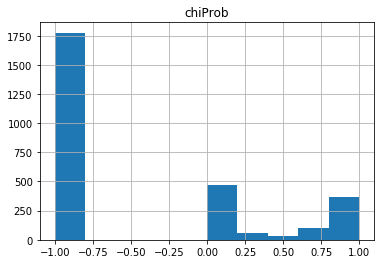

In [28]:
Dst.hist(column='chiProb')

In [20]:
Dst[['mcErrors','pValue','ErrM','chiProb']].describe()

,mcErrors,pValue,ErrM,chiProb
count,2803.000000,2803.0,2803.000000,2803.000000
mean,610.276133,0.0,0.002331,-0.472026
std,321.595104,0.0,0.002668,0.740848
min,0.000000,0.0,0.000009,-1.000000
25%,512.000000,0.0,0.000924,-1.000000
50%,512.000000,0.0,0.001718,-1.000000
75%,512.000000,0.0,0.002873,0.009172
max,1530.000000,0.0,0.046152,1.000000


In [21]:
matchSet = Dst[['isSignal','D0Match','slowpiMatch','KsMatch','PpMatch','PmMatch','PzMatch','g1Match','g2Match','g1E','g2E']]

In [22]:
matchSet.describe()

,isSignal,D0Match,slowpiMatch,KsMatch,PpMatch,PmMatch,PzMatch,g1Match,g2Match,g1E,g2E
count,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.00000,2803.000000,2803.000000
mean,0.002497,0.004995,0.608634,0.765252,0.979665,0.966465,0.121299,0.559401,0.58259,0.146406,0.162203
std,0.049920,0.070509,0.488143,0.423917,0.141170,0.180062,0.326532,0.496548,0.49322,0.115774,0.129768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.030141,0.030206
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.080355,0.076327
50%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,0.119236,0.129596
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,0.178281,0.196695
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.210065,1.210065


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7152a9ef0>,
      dtype=object)

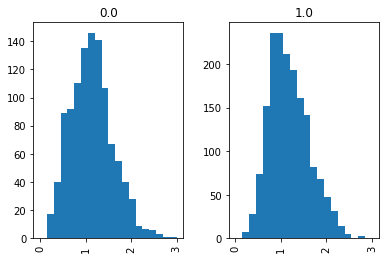

In [23]:
Dst.hist(column='p',by='slowpiMatch',bins=20,range=(0.,3.))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7152a8cf8>,
      dtype=object)

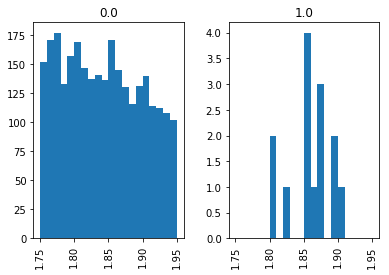

In [24]:
Dst.hist(column='D0M',by='D0Match',bins=20,range=(1.75,1.95))#,bins=16,range=(0.,0.16))

(array([ 517., 1135.,  643.,   71.,   33.,   23.,   20.,   14.,   14.,
          10.,   11.,   15.,    9.,    3.,    9.,    4.,    3.,    2.,
           2.,    0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
 <a list of 20 Patch objects>)

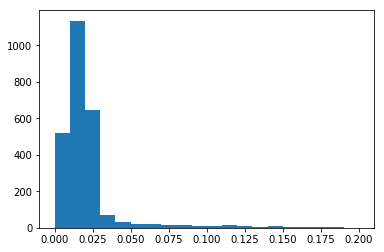

In [27]:
plt.hist(Dst.M-Dst.D0M-.1349,bins=20,range=(0.,.2))

In [ ]:
#hist2d(data.p[isPion], data.pionID[isPion], bins=(50,100), range=([0,3],[-0.1, 1.1]), norm=LogNorm()#)
#import matplotlib.pyplot as plt
h=plt.hist2d(Dst.g1Match,Dst.g2Match,bins=(2,2),range=([0,1],[0,1]))#,xlabel='gamma1 matched',ylabel='gamma2 matched')      
#xlabel('gamma1 matched')
#ylabel('gamma2 matched')
plt.colorbar(h[3])


In [ ]:
h=plt.hist2d(Dst.chiProb,Dst.mcErrors)
plt.colorbar(h[3])

In [ ]:
plt.hist2d(Dst.g1E,Dst.g2E)

In [ ]:
plt.hist(Dst.g1E-Dst.g2E)

In [ ]:
Dst.hist('PzM')

In [ ]:
Dst.plot.scatter('Pzp','PzMatch')

In [ ]:
Dst.hist('PzM',by='PzMatch',bins=20,range=(.13,.16))

In [ ]:
Dst.hist('KsM',by='KsMatch',bins=20,range=(.46,.54))